### CHECK KAGGLE TOKEN & LOAD DATASET

In [ ]:
import os
import zipfile

# Function to download dataset
def download_dataset(dataset_name, zip_file_name):
    os.system(f'kaggle datasets download -d {dataset_name}')
    if not os.path.exists(zip_file_name):
        raise FileNotFoundError(f"Dataset '{zip_file_name}' not found after download.")
    return zip_file_name

# Attempt to extract ZIP file
def extract_zip(file_name, extract_to):
    try:
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Dataset extracted successfully.")
    except zipfile.BadZipFile:
        print(f"Bad ZIP file: {file_name}. Re-downloading...")
        os.remove(file_name)
        download_dataset(dataset_name, file_name)
        extract_zip(file_name, extract_to)

# Set dataset details
dataset_name = 'nelgiriyewithana/global-weather-repository'
zip_file_name = 'global-weather-repository.zip'
extract_dir = "global-weather-repository"

# Ensure Kaggle credentials
kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError("Kaggle API credentials not found. Place 'kaggle.json' in ~/.kaggle.")

os.chmod(kaggle_json_path, 0o600)

# Download and extract
download_dataset(dataset_name, zip_file_name)
extract_zip(zip_file_name, extract_dir)


Bad ZIP file: global-weather-repository.zip. Re-downloading...
Dataset extracted successfully.


### DATA PREPARATION

In [43]:
import pandas as pd

# Load the dataset (update the file path if necessary)
file_path = 'global-weather-repository/GlobalWeatherRepository.csv'  # Replace with actual dataset file path
data = pd.read_csv(file_path)

# Filter for rows where country is "Thailand" and location_name is "Bangkok"
filtered_data = data[(data['country'] == 'Thailand') & (data['location_name'] == 'Bangkok')]

# Select only the required columns
filtered_data = filtered_data[['air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_Carbon_Monoxide','air_quality_PM2.5','temperature_celsius','humidity', 'humidity']]

# Save the filtered data to a new CSV file
output_file_path = 'filtered_data_thailand_bangkok.csv'
filtered_data.to_csv(output_file_path, index=False)

print("Filtered data saved to", output_file_path)


Filtered data saved to filtered_data_thailand_bangkok.csv


In [17]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

# Load the dataset (update the file path if necessary)
file_path = 'filtered_data_thailand_bangkok.csv'  # Replace with the actual path
data = pd.read_csv(file_path)

# Data Overview
print("Initial data overview:\n", data.info())
print("\nData sample:\n", data.head())

# Step 1: Handle Missing Values
# Fill or drop missing values for air_quality_PM2.5 if necessary
data['air_quality_PM2.5'] = data['air_quality_PM2.5'].fillna(data['air_quality_PM2.5'].median())

# Step 4: Normalize Data
scaler = StandardScaler()
data['air_quality_PM2.5_normalized'] = scaler.fit_transform(data[['air_quality_PM2.5']])
data['temperature_celsius_normalized'] = scaler.fit_transform(data[['temperature_celsius']])
data['humidity_normalized'] = scaler.fit_transform(data[['humidity']])

# Step 5: Drop Unnecessary Columns
# Drop 'last_updated' and 'last_updated_epoch' if no longer needed
data.drop(columns=['country','location_name','last_updated', 'last_updated_epoch'], inplace=True)

# Save the preprocessed data to a new CSV file
output_file_path = 'prepared_data_thailand_bangkok.csv'
data.to_csv(output_file_path, index=False)

print("\nData preparation and feature engineering completed. Data saved to", output_file_path)
print("\nSample of prepared data:\n", data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              184 non-null    object 
 1   location_name        184 non-null    object 
 2   last_updated         184 non-null    object 
 3   last_updated_epoch   184 non-null    int64  
 4   temperature_celsius  184 non-null    float64
 5   humidity             184 non-null    int64  
 6   air_quality_PM2.5    184 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 10.2+ KB
Initial data overview:
 None

Data sample:
     country location_name      last_updated  last_updated_epoch  \
0  Thailand       Bangkok  2024-05-16 15:45          1715849100   
1  Thailand       Bangkok  2024-05-16 21:15          1715868900   
2  Thailand       Bangkok  2024-05-18 21:30          1716042600   
3  Thailand       Bangkok  2024-05-19 21:15          1716128100   
4  T

In [5]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('prepared_data_thailand_bangkok.csv')

# Drop the specified columns
df = df.drop(columns=['country', 'location_name', 'weekday'])

# Save the modified DataFrame back to a CSV file
df.to_csv('prepared_data_thailand_bangkok.csv', index=False)


### ARIMA

Preparing data...

Training ARIMA model...

Model Performance Metrics:
Mean Squared Error: 2622.45
Root Mean Squared Error: 51.21
Mean Absolute Error: 46.75
R² Score: -0.42

Next Day Prediction:
Predicted PM2.5 value for next day: 88.53

Plotting results...


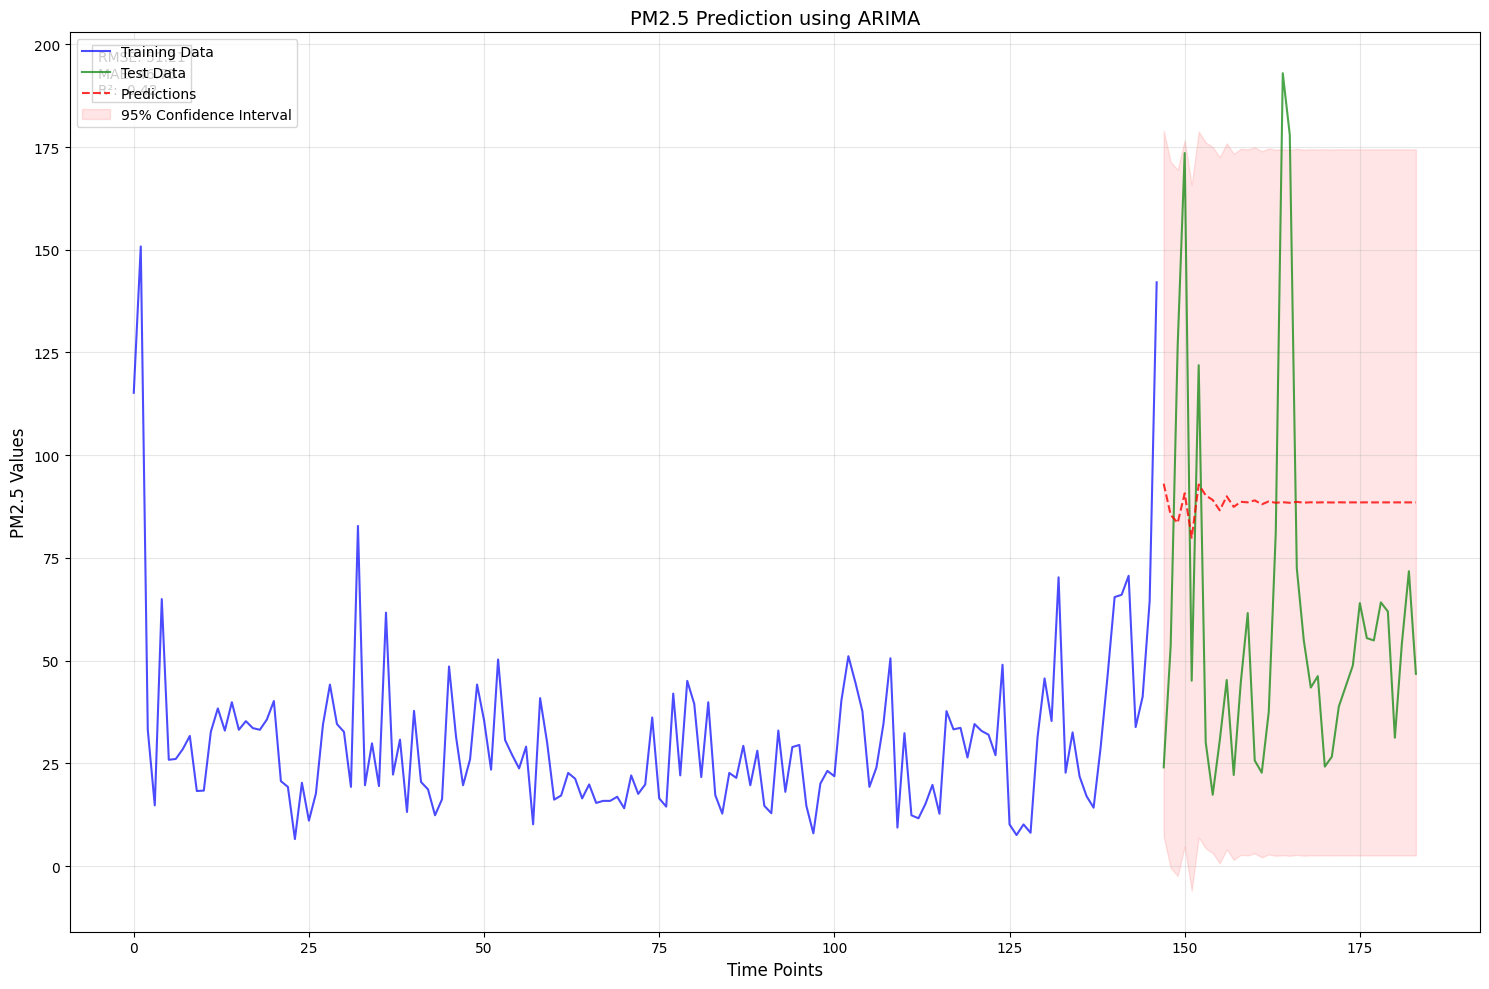

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:      air_quality_PM2.5   No. Observations:                  147
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -635.523
Date:                Tue, 19 Nov 2024   AIC                           1283.047
Time:                        17:21:26   BIC                           1300.949
Sample:                             0   HQIC                          1290.321
                                - 147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5109      0.070     -7.327      0.000      -0.648      -0.374
ar.L2         -0.4134      0.119     -3.472      0.001      -0.647      -0.180
ar.L3         -0.2920      0.08

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Read the CSV file
data = pd.read_csv('filtered_data_thailand_bangkok.csv')

# Create features for time series forecasting
def create_features(df):
    """Create time series features for the ARIMA model"""
    df_features = pd.DataFrame()
    
    # Use the target variable (air_quality_PM2.5) for time series prediction
    df_features['PM2.5'] = df['air_quality_PM2.5']
    
    return df_features

def prepare_data(df, target_col='air_quality_PM2.5'):
    """Prepare data for ARIMA model"""
    # Create features
    features = create_features(df)
    target = df[target_col]
    
    # Remove rows with NaN values (created by lag/rolling features)
    features = features.dropna()
    target = target[features.index]
    
    # Split the data (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test

def train_arima(y_train, y_test):
    """Train ARIMA model and make predictions"""
    # Fit ARIMA model
    arima_model = ARIMA(y_train, order=(5, 1, 0))  # Example ARIMA(5,1,0) model
    arima_model_fit = arima_model.fit()
    
    # Make predictions
    predictions = arima_model_fit.forecast(steps=len(y_test))
    
    return predictions, arima_model_fit

def plot_results(y_train, y_test, predictions):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot test data and predictions
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Test Data', color='green', alpha=0.7)
    plt.plot(test_range, predictions, 
             label='Predictions', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals using prediction std
    residuals = y_test - predictions
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions - 2*std_dev,
                     predictions + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('PM2.5 Prediction using ARIMA', fontsize=14)
    plt.xlabel('Time Points', fontsize=12)
    plt.ylabel('PM2.5 Values', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(arima_model_fit):
    """Plot feature importance for ARIMA model (optional)"""
    # ARIMA does not have explicit feature importance like tree-based models,
    # but we can plot residuals or coefficients if needed
    print("ARIMA Model Summary:")
    print(arima_model_fit.summary())

# Prepare the data
print("Preparing data...")
X_train, X_test, y_train, y_test = prepare_data(data)

# Train model and make predictions
print("\nTraining ARIMA model...")
predictions, arima_model_fit = train_arima(y_train, y_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print results
print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Make next day prediction
print("\nNext Day Prediction:")

# If predictions are a pandas Series or numpy array, access the last element
next_day_prediction = predictions[-1] if isinstance(predictions, np.ndarray) else predictions.iloc[-1]
print(f"Predicted PM2.5 value for next day: {next_day_prediction:.2f}")

# Visualize results
print("\nPlotting results...")
plot_results(y_train, y_test, predictions)

# Optional: Print the ARIMA model summary
plot_feature_importance(arima_model_fit)


### XGBoost



Training XGBoost model...

Model Performance Metrics:
Mean Squared Error: 559.87
Root Mean Squared Error: 23.66
Mean Absolute Error: 13.79
R² Score: 0.71

Next Day Prediction:
Predicted PM2.5 value for next day: 44.59

Plotting results...


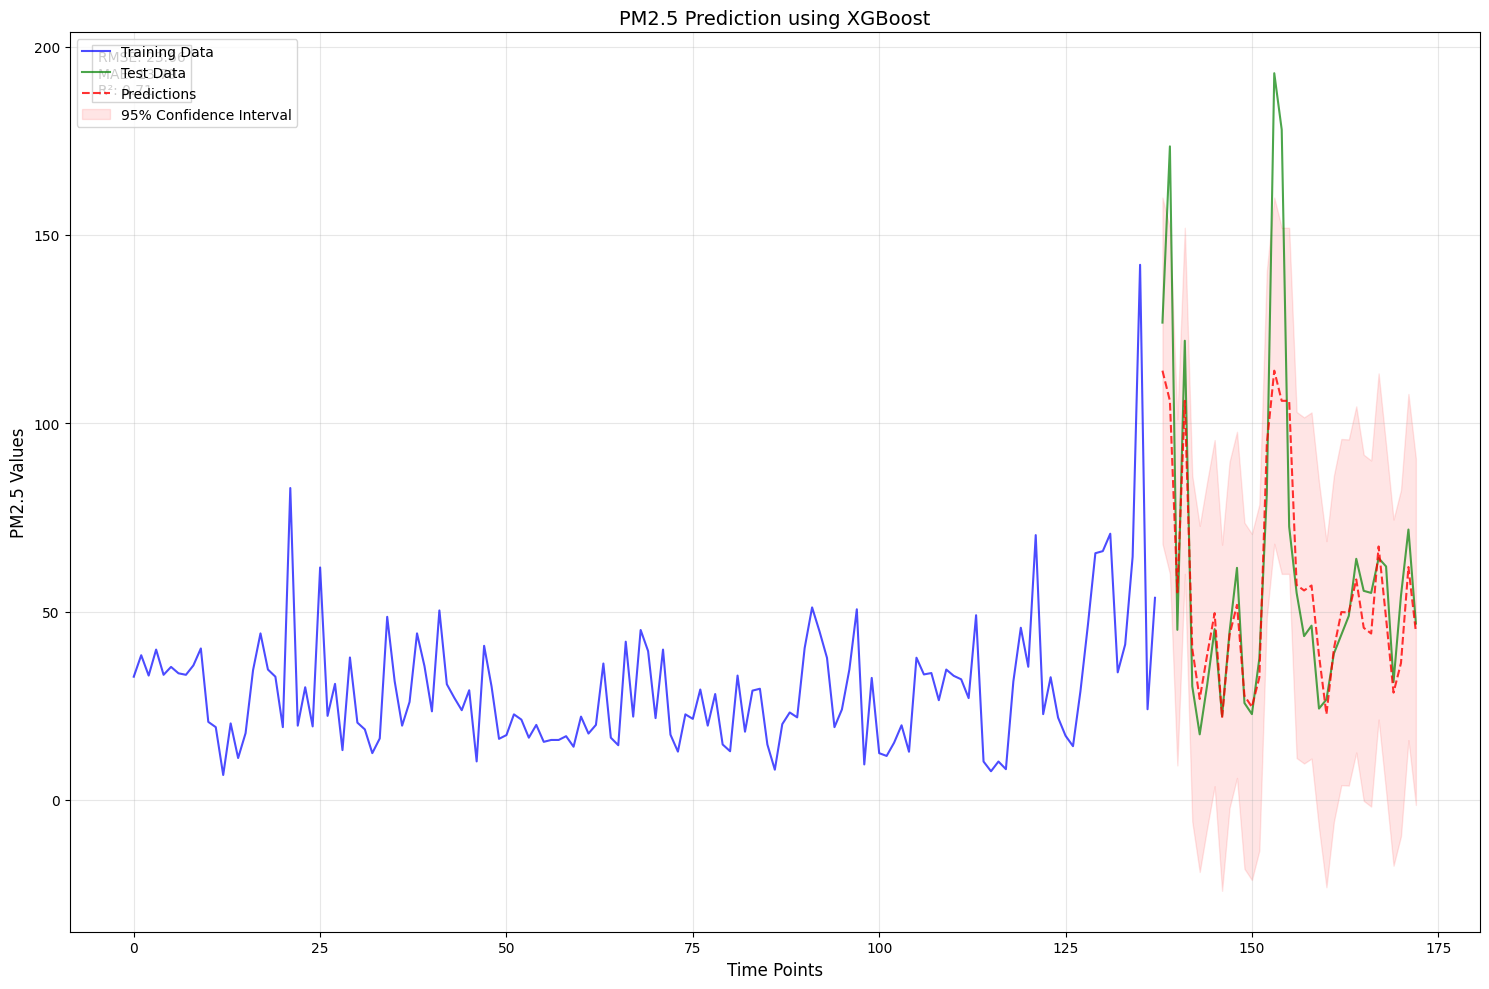

In [61]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load pre-split data from CSV files
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

def train_xgboost(X_train, y_train, X_test):
    """Train XGBoost model and make predictions"""
    # Initialize and train the model
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        min_child_weight=5,
        learning_rate=0.1,
        random_state=42
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    predictions = xgb_model.predict(X_test)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return predictions, feature_importance

def plot_results(y_train, y_test, predictions):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Flatten y_test in case it's a DataFrame or Series with extra dimensions
    y_test = y_test.values.flatten() if isinstance(y_test, pd.DataFrame) else y_test
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot test data and predictions
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Test Data', color='green', alpha=0.7)
    plt.plot(test_range, predictions, 
             label='Predictions', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals using prediction std
    residuals = y_test - predictions
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions - 2*std_dev,
                     predictions + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('PM2.5 Prediction using XGBoost', fontsize=14)
    plt.xlabel('Time Points', fontsize=12)
    plt.ylabel('PM2.5 Values', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()


def plot_feature_importance(feature_importance):
    """Plot feature importance"""
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['feature'][:10], 
             feature_importance['importance'][:10])
    plt.title('Top 10 Most Important Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Train model and make predictions
print("\nTraining XGBoost model...")
predictions, feature_importance = train_xgboost(X_train, y_train, X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print results
print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Make next day prediction
print("\nNext Day Prediction:")
next_day_prediction = predictions[-1]  # Predicting for the last test sample
print(f"Predicted PM2.5 value for next day: {next_day_prediction:.2f}")

# Visualize results
print("\nPlotting results...")
plot_results(y_train, y_test, predictions)


### Random Forest 


Preparing data...

Training Random Forest model...

Model Performance Metrics:
Mean Squared Error: 825.69
Root Mean Squared Error: 28.73
Mean Absolute Error: 14.48
R² Score: 0.57

Next Day Prediction:
Predicted PM2.5 value for next day: 35.53

Plotting results...


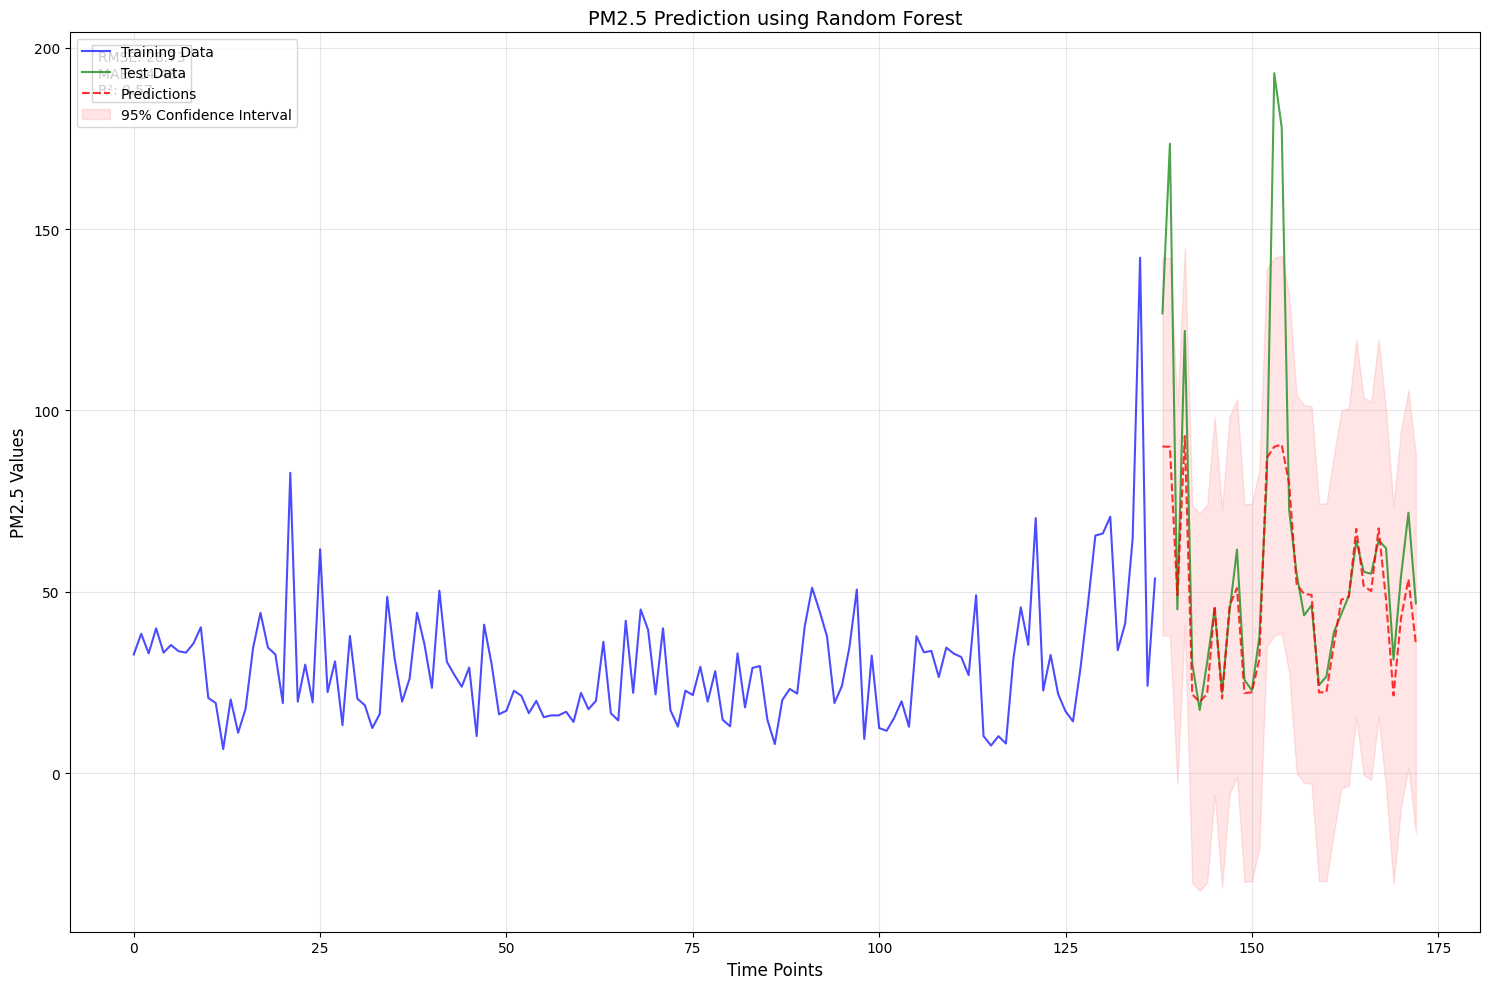

149    126.725
150    173.530
151     45.140
152    121.915
153     30.155
154     17.390
155     30.525
156     45.325
157     22.200
158     44.585
159     61.605
160     25.715
161     22.755
162     37.555
163     81.215
164    192.955
165    177.970
166     72.520
167     54.945
168     43.475
169     46.250
170     24.235
171     26.640
172     38.850
173     43.845
174     48.840
175     64.010
176     55.500
177     54.945
178     64.195
179     61.975
180     31.265
181     54.205
182     71.780
183     46.805
Name: air_quality_PM2.5, dtype: float64 [90.02716452 89.95802369 49.08071988 92.90078512 21.68512645 19.59518815
 21.85428005 46.11165073 20.57255075 46.13420891 51.01011498 22.05531367
 22.27723927 31.49815893 86.86813512 89.95802369 90.57067702 79.66035488
 52.06238147 49.3985848  49.10863897 22.22395262 22.31421452 35.42926662
 47.82267121 48.54158688 67.35069629 51.55325647 50.17542313 67.45816165
 47.68847125 21.39326036 42.62152141 53.45188609 35.53023433]


In [62]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('filtered_data_thailand_bangkok.csv')

def create_features(df):
    """Create time series features for the Random Forest model"""
    df_features = pd.DataFrame()
    
    # Use all available features
    df_features['PM10'] = df['air_quality_PM10']
    df_features['EPA_index'] = df['air_quality_us-epa-index']
    df_features['CO'] = df['air_quality_Carbon_Monoxide']
    df_features['temperature'] = df['temperature_celsius']
    df_features['humidity'] = df['humidity']
    
    # Create lagged features for PM2.5
    for i in range(1, 4):  # Create 3 lag features
        df_features[f'PM25_lag_{i}'] = df['air_quality_PM2.5'].shift(i)
    
    # Create rolling mean features
    for window in [3, 6, 12]:
        df_features[f'PM25_rolling_mean_{window}'] = df['air_quality_PM2.5'].rolling(window=window).mean()
        df_features[f'PM10_rolling_mean_{window}'] = df['air_quality_PM10'].rolling(window=window).mean()
        df_features[f'CO_rolling_mean_{window}'] = df['air_quality_Carbon_Monoxide'].rolling(window=window).mean()
    
    return df_features

def prepare_data(df, target_col='air_quality_PM2.5'):
    """Prepare data for Random Forest model"""
    # Create features
    features = create_features(df)
    target = df[target_col]
    
    # Remove rows with NaN values (created by lag/rolling features)
    features = features.dropna()
    target = target[features.index]
    
    # Split the data (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, shuffle=False
    )
    
    # Save the training and testing data to separate files
    X_train.to_csv('X_train.csv', index=False)
    X_test.to_csv('X_test.csv', index=False)
    y_train.to_csv('y_train.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)
    
    return X_train, X_test, y_train, y_test

def train_random_forest(X_train, y_train, X_test):
    """Train Random Forest model and make predictions"""
    # Initialize and train the model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    predictions = rf_model.predict(X_test)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return predictions, feature_importance

def plot_results(y_train, y_test, predictions):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot test data and predictions
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Test Data', color='green', alpha=0.7)
    plt.plot(test_range, predictions, 
             label='Predictions', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals using prediction std
    residuals = y_test - predictions
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions - 2*std_dev,
                     predictions + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('PM2.5 Prediction using Random Forest', fontsize=14)
    plt.xlabel('Time Points', fontsize=12)
    plt.ylabel('PM2.5 Values', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance):
    """Plot feature importance"""
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['feature'][:10], 
             feature_importance['importance'][:10])
    plt.title('Top 10 Most Important Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Prepare the data
print("Preparing data...")
X_train, X_test, y_train, y_test = prepare_data(data)

# Train model and make predictions
print("\nTraining Random Forest model...")
predictions, feature_importance = train_random_forest(X_train, y_train, X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print results
print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Make next day prediction
print("\nNext Day Prediction:")
last_features = X_test.iloc[-1:].copy()
next_day_prediction = pd.DataFrame(predictions).iloc[-1:].values[0][0]
print(f"Predicted PM2.5 value for next day: {next_day_prediction:.2f}")

# Visualize results
print("\nPlotting results...")
plot_results(y_train, y_test, predictions)
print(y_test, predictions)
